In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [2]:
try:
    sales_train_df = pd.read_csv('train.csv', low_memory=False)
    store_info_df = pd.read_csv('store.csv', low_memory=False)
    print("Tải dữ liệu gốc thành công.")
except FileNotFoundError:
    print("Không tìm thấy file, tạo dữ liệu giả.")
    sales_data = {
        'Store': [1]*10 + [2]*10,
        'DayOfWeek': [5,4,3,2,1,5,4,3,2,1]*2,
        'Date': pd.date_range(start='2015-07-01', periods=10).tolist() * 2,
        'Sales': [5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,
                  6000,6500,8500,14000,5000,5800,15500,8600,8700,7300],
        'Customers': [555,625,821,1498,559,589,1414,833,687,681,
                      600,650,830,1500,560,590,1420,840,690,685],
        'Open': [1]*20,
        'Promo': [1,1,1,1,1,0,0,0,0,0]*2,
        'StateHoliday': ['0']*20,
        'SchoolHoliday': [1]*20
    }
    store_info_data = {
        'Store': [1, 2],
        'StoreType': ['c', 'a'],
        'Assortment': ['a', 'a'],
        'CompetitionDistance': [1270.0, 570.0],
        'CompetitionOpenSinceMonth': [9.0, 11.0],
        'CompetitionOpenSinceYear': [2008.0, 2007.0],
        'Promo2': [0, 1],
        'Promo2SinceWeek': [np.nan, 13.0],
        'Promo2SinceYear': [np.nan, 2010.0],
        'PromoInterval': [np.nan, 'Jan,Apr,Jul,Oct']
    }
    sales_train_df = pd.DataFrame(sales_data)
    store_info_df = pd.DataFrame(store_info_data)

print(sales_train_df.head())


Không tìm thấy file, tạo dữ liệu giả.
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-01   5263        555     1      1            0   
1      1          4 2015-07-02   6064        625     1      1            0   
2      1          3 2015-07-03   8314        821     1      1            0   
3      1          2 2015-07-04  13995       1498     1      1            0   
4      1          1 2015-07-05   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


In [3]:
sales_train_all_df = pd.merge(sales_train_df, store_info_df, on='Store', how='inner')

# Xử lý missing
sales_train_all_df['CompetitionDistance'].fillna(sales_train_all_df['CompetitionDistance'].median(), inplace=True)
for col in ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']:
    sales_train_all_df[col].fillna(0, inplace=True)

# Đổi Date sang datetime
sales_train_all_df['Date'] = pd.to_datetime(sales_train_all_df['Date'])

# Loại bỏ ngày không mở cửa hoặc sales = 0
sales_train_all_df = sales_train_all_df[(sales_train_all_df['Open'] == 1) & (sales_train_all_df['Sales'] > 0)]
sales_train_all_df.drop(['Open'], axis=1, inplace=True)

print(sales_train_all_df.head())


   Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0      1          5 2015-07-01   5263        555      1            0   
1      1          4 2015-07-02   6064        625      1            0   
2      1          3 2015-07-03   8314        821      1            0   
3      1          2 2015-07-04  13995       1498      1            0   
4      1          1 2015-07-05   4822        559      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0

C:\Users\Admin\AppData\Local\Temp\ipykernel_18148\4125979981.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_train_all_df['CompetitionDistance'].fillna(sales_train_all_df['CompetitionDistance'].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18148\4125979981.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      20 non-null     int64         
 1   DayOfWeek                  20 non-null     int64         
 2   Date                       20 non-null     datetime64[ns]
 3   Sales                      20 non-null     int64         
 4   Customers                  20 non-null     int64         
 5   Promo                      20 non-null     int64         
 6   StateHoliday               20 non-null     object        
 7   SchoolHoliday              20 non-null     int64         
 8   StoreType                  20 non-null     object        
 9   Assortment                 20 non-null     object        
 10  CompetitionDistance        20 non-null     float64       
 11  CompetitionOpenSinceMonth  20 non-null     float64       
 12  Competitio

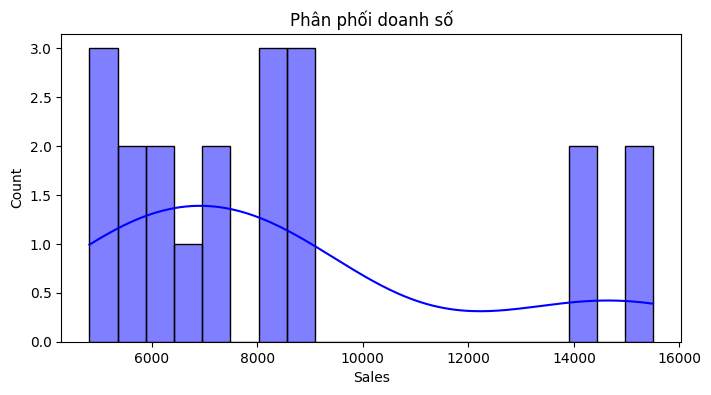

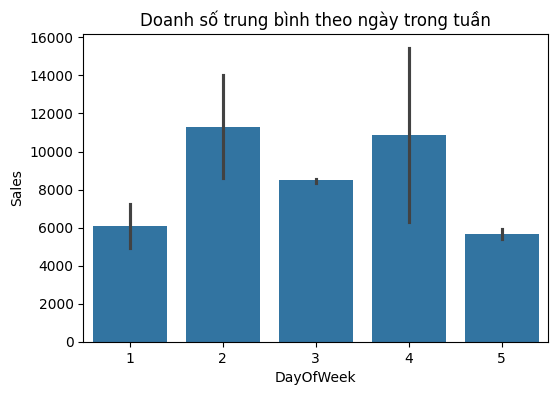

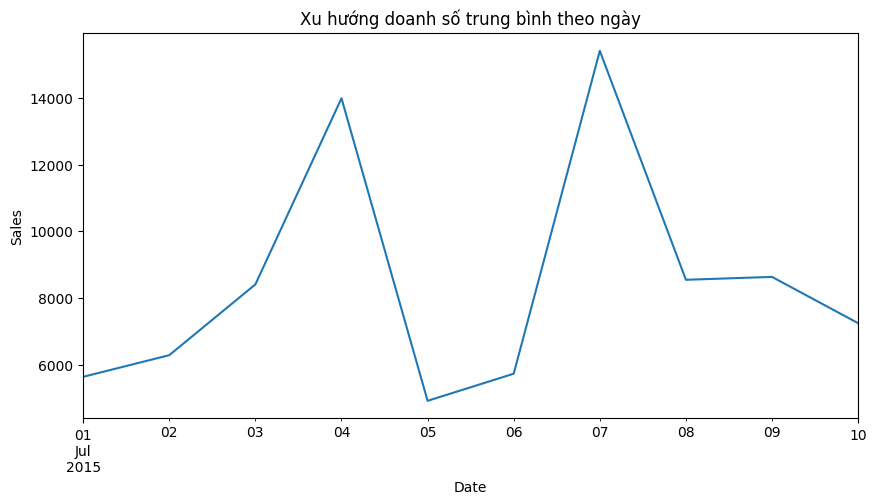

In [4]:
# Thông tin dữ liệu
print(sales_train_all_df.info())

# Biểu đồ phân phối doanh số
plt.figure(figsize=(8,4))
sns.histplot(sales_train_all_df['Sales'], bins=20, kde=True, color='blue')
plt.title('Phân phối doanh số')
plt.show()

# Doanh số trung bình theo ngày trong tuần
plt.figure(figsize=(6,4))
sns.barplot(data=sales_train_all_df, x='DayOfWeek', y='Sales', estimator=np.mean)
plt.title('Doanh số trung bình theo ngày trong tuần')
plt.show()

# Xu hướng doanh số
plt.figure(figsize=(10,5))
sales_train_all_df.groupby('Date')['Sales'].mean().plot()
plt.title('Xu hướng doanh số trung bình theo ngày')
plt.ylabel('Sales')
plt.show()


In [5]:
# Thêm đặc trưng thời gian
sales_train_all_df['Year'] = sales_train_all_df['Date'].dt.year
sales_train_all_df['Month'] = sales_train_all_df['Date'].dt.month
sales_train_all_df['Day'] = sales_train_all_df['Date'].dt.day
sales_train_all_df['WeekOfYear'] = sales_train_all_df['Date'].dt.isocalendar().week.astype(int)

# One-hot encoding
categorical_features = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
sales_train_all_df = pd.get_dummies(sales_train_all_df, columns=categorical_features, drop_first=True)

# Chọn features & target
features = ['Store', 'DayOfWeek', 'Customers', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear', 'StoreType_b', 'StoreType_c',
            'StoreType_d', 'Assortment_b', 'Assortment_c', 'StateHoliday_a', 'StateHoliday_b',
            'StateHoliday_c', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
            'PromoInterval_Mar,Jun,Sept,Dec']
target = 'Sales'

# Đảm bảo cột đủ
for col in features:
    if col not in sales_train_all_df.columns:
        sales_train_all_df[col] = 0

sales_train_all_df = sales_train_all_df[['Date'] + features + [target]]

# Hàm tạo chuỗi
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length, 1:-1].values)
        y.append(data.iloc[i+seq_length, -1])
    return np.array(X), np.array(y)

# Scale
SEQUENCE_LENGTH = 7
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sales_train_all_df.drop(['Date'], axis=1).values)
scaled_df = pd.DataFrame(scaled_data, columns=sales_train_all_df.columns[1:])
X, y = create_sequences(scaled_df, SEQUENCE_LENGTH)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (13, 7, 25) y shape: (13,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0364 - val_loss: 0.4804
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0305 - val_loss: 0.4177
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0108 - val_loss: 0.3775
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0345 - val_loss: 0.3673
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0291 - val_loss: 0.3696
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0280 - val_loss: 0.3853
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0195 - val_loss: 0.3959
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0139 - val_loss: 0.4137
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0271 - val_loss: 0.4358
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0143 - val_loss: 0.4573
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0225 - val_loss: 0.4726
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0195 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step

RMSE: 5303.88


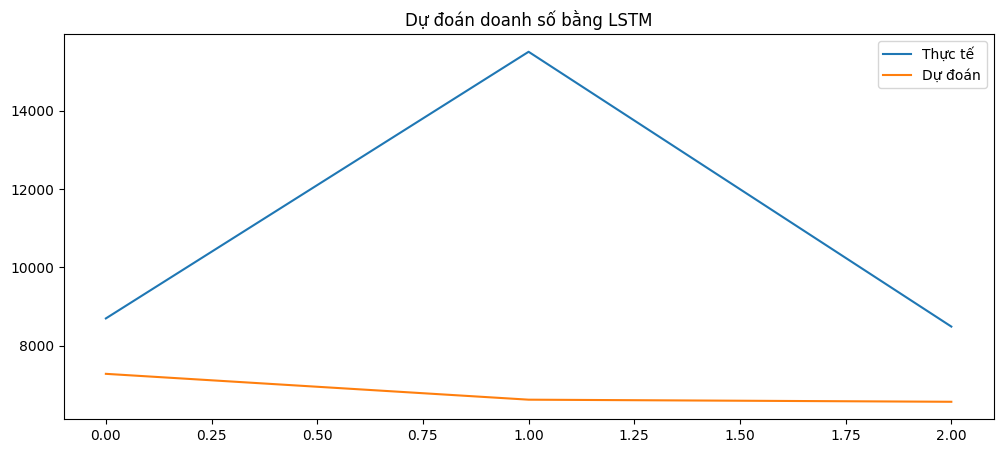

In [7]:
predictions = model.predict(X_test)

y_test_inv = scaler.inverse_transform(np.hstack([np.zeros((len(y_test), scaled_data.shape[1]-1)), y_test.reshape(-1,1)]))[:,-1]
pred_inv = scaler.inverse_transform(np.hstack([np.zeros((len(predictions), scaled_data.shape[1]-1)), predictions]))[:,-1]

rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
print(f"\nRMSE: {rmse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Thực tế')
plt.plot(pred_inv, label='Dự đoán')
plt.legend()
plt.title('Dự đoán doanh số bằng LSTM')
plt.show()
